In [1]:
from dataset import dataset, Encoder, Collate
from model import CRNNModel
import transform

import torch
from torch.utils.data import DataLoader
import albumentations as A
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['image.cmap'] = 'gray'

DATASET_DIR = '/mnt/d/Machine-Learning/Datasets/iamdataset/uncompressed'

In [2]:
_, _, testset = dataset('IAM', DATASET_DIR, 
                        csv_file_path='IAM_df.csv', 
                        default_partition=False, 
                        partition=(0.7, 0.1, 0.2),
                        shuffle=False, seed=42)

In [3]:
print(len(testset))
testset.data.head()

2670


,Image,Segmentation,Transcription,Threshold
0,l07-135-08,err,the river and in and out of the other boats.,175
1,l07-138-00,ok,"It was a warm, still evening; the plop of",181
2,l07-138-01,ok,fish and the gentle putter of the engine,185
3,l07-138-02,ok,"were infinitely soothing after city noises,",183
4,l07-138-03,ok,and I began to look forward to my life,185


In [4]:
encoder = Encoder(testset.charset)
collater = Collate(encoder)

test_loader = DataLoader(testset,
    batch_size=16,
    shuffle=True, 
    collate_fn=collater,
    num_workers=0
)

test_batch = next(iter(test_loader))
images, targets, target_lengths, ground_truth = test_batch

In [5]:
model = CRNNModel(vocab_size=79, time_steps=100)

device = torch.device('cpu')

dev = 'cpu'

checkpoint = torch.load(
                'checkpoints/training_state.pth', 
                map_location=device)

model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [6]:
with torch.no_grad():

    model.to(dev)
    images = images.to(dev)
    targets = targets.to(dev)
    target_lengths = target_lengths.to(dev)

    preds = model(images)
    preds_decoded = encoder.best_path_decode(
        preds, return_text=True)

In [7]:
ground_truth

('in sharing his discomfort with Peggy.',
 'early smells, the dark bosoms of',
 "and in Liverpool they'd want sea-farers.",
 '"Neither can Nigel," smiled Diana.',
 '"Not in Pericles, old man." "Why not?"',
 'radar glowed. Occasionally minute spots',
 'then Philip was so certain that Nicholas',
 '"That is a pretty dress," Lilyan commented, obviously sensing',
 'interest to The George, unhappily destroyed by German',
 'crowd and drove back to Vence.',
 '"Intended for Plas Newydd, this lot is. Paid for,',
 'over his head and yawned agape,',
 'Between all the interested parties, the final',
 'in her quivering flesh. "You\'ve an answer - of sorts - for everything," she',
 "necks before you can say 'knife'. It wouldn't",
 'with a cyst on her ear ... ?"')

In [8]:
preds_decoded

['n shasing his discom fort witl Peggey.',
 'larby smetls, the dark busomus onf',
 "and in live poat they'd wat sea-farers.",
 '"Weither Can Nigel," smited Diana.',
 '"Nat in Periles, old man." "Wthy not.?"',
 'sadar gloved. looisnally sinnte speorb',
 'then Rrily was so certen thatNicholas',
 '\'That is a posettyr deswr" Citras commented, aburiousty sensing',
 'inteest to The Geonge, unhappily destrogead by Gemen',
 'croud and drove boacke to lende.',
 '"\'Intended for Plas vewryald, thir lotis. Paid for,',
 'oner his lead and yawneod agopoeo',
 'bestees ad the ssteresea bostis, tdepsia',
 'in her quivering flesh. "You\'ve an ausurer - of sats -for eveything," the',
 "meats before yoa can say 'bniffe' It womulahi't",
 'with a oyst on her ear..a?']

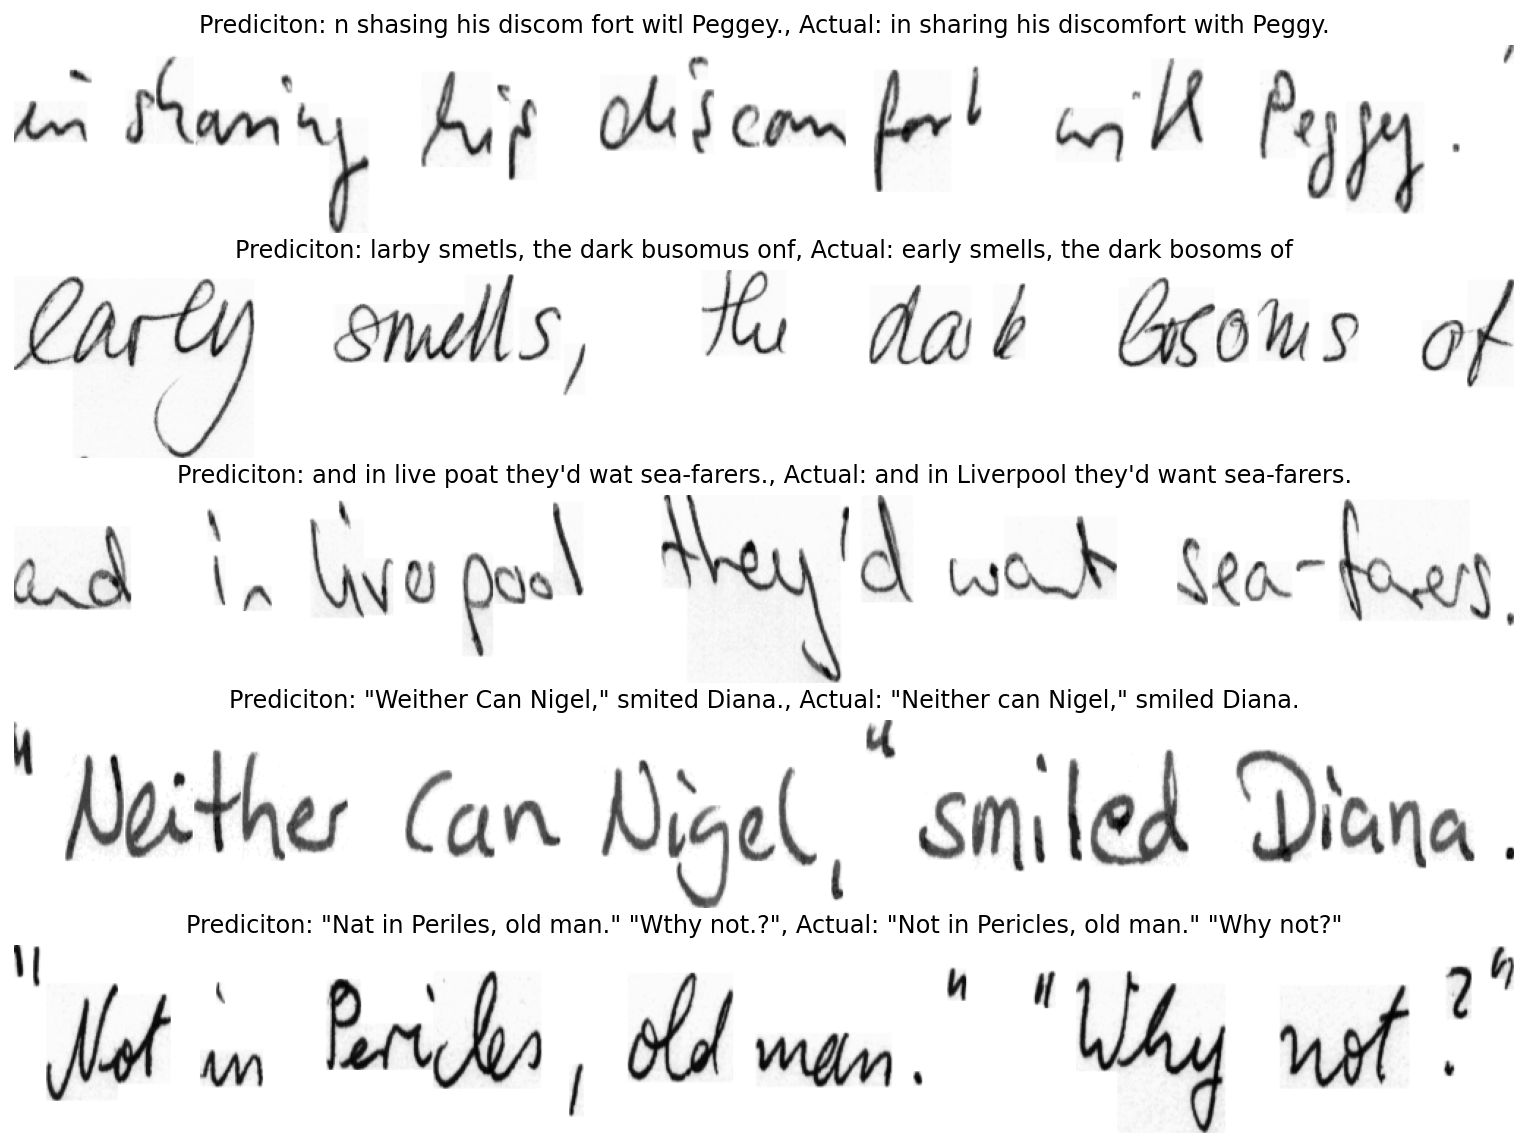

In [9]:
f, axes = plt.subplots(nrows=len(images[:5]), ncols=1, figsize=(20, 10))

for ax in axes:
    ax.axis('off')

for i, image in enumerate(images[:5]):
    image = torch.squeeze(image, dim=0).numpy()
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Prediciton: {preds_decoded[i]}, Actual: {ground_truth[i]}")

## Inference on real world images

In [10]:
real_image = cv2.imread('images/testimage.jpg', cv2.IMREAD_GRAYSCALE)

In [11]:
transforms = A.Compose([
                A.augmentations.geometric.Resize(
                    height=128, width=1024, p=1.0, always_apply=True),
                transform.Rotate(always_apply=True, p=1.0),
                transform.ToTensor(always_apply=True, p=1.0)
            ])

image = transforms(image=real_image)['image']

In [12]:
with torch.no_grad():

    model.to(dev)
    images = torch.unsqueeze(image, dim=0)
    images = images.to(dev)

    preds = model(images)
    preds_decoded = encoder.best_path_decode(
        preds, return_text=True)

Text(0.5, 1.0, 'Prediciton: I0 colrege of Engineening ande rManagemant')

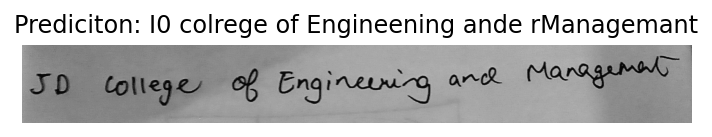

In [16]:
plt.imshow(real_image, cmap='gray')
plt.axis('off')
plt.title(f"Prediciton: {preds_decoded[0]}")